Maciej Filipowicz - Sentiment Classification - 10.03.2019

This section shows the LSTM and ULMFIT application on US Airline tweeter data for sentiment classification purpose.
<br> The notebook is built on the following activities: </br>
* Prepare data for deep learning (not much description here as partly it was convered in Notebook_part1.
* Run following LSTMs:
    * LSTM - 1-hot encoded X matrix
    * LSTM - embedding layer learned during training
    * LSTM - embedding layer pretrained from Twitter400 dataset
    * LSTM - embedding layer pretrained from GoogleNews 300 dataset
    * CNN-LSTM - chosen x representation based on vanilla-LSTM scores from previous points
* Run the following UMLFIT:
    * First model run on the same twitter text as other DL and ML models to see if accuracy improved.
    * Second model with twitter text light cleansing 
    * Third model selecting only highly confident sentiment tweets


# Libraries and data preparation

## Libraries


In [1]:
# General libraries
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from functools import partial
import io

# Data and text manipulation
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()   
from nltk.tokenize import TweetTokenizer
import re as regex

# keras - Deep Learning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer as Keras_Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils
from keras.layers import Dense, Activation, Bidirectional, Embedding, Input, Dropout 
from keras.layers import CuDNNLSTM, LSTM, CuDNNGRU, GRU
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import RMSprop
import tensorflow as tf
from keras.optimizers import RMSprop , Adam
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

# fastai - Deep Learning
import fastai
from fastai import *
from fastai.text import * 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


## Mount the Google Drive

In [2]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df_tweet=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Tweets.csv")

In [4]:
df_tweet.shape

(14640, 15)

## Data preparation

### Cleansing twitter text

Cleansing of text is done in the same way as cleansing for Machine Learning algorithms.

In [0]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [0]:
 def clean_tweets(tweet):
    
    # remove the owner
    tweet = re.sub(r'@[A-Za-z0-9]+','', tweet)
    
    # remove stock market tickers like $GE
    
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # remove non-alphabetical strings 
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet) # to consider, some strings like '...' might mean irritation
 
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, #lower() function for tweets
                               strip_handles=True, 
                               reduce_len=True)
    
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation
            #stem_word = stemmer.stem(word) # stemming word
            lem_word = lemmatizer.lemmatize(word,get_wordnet_pos(word))
            tweets_clean.append(lem_word)
 
    return tweets_clean
 

In [0]:
df_tweet['cleaned_text_tokenized']=df_tweet['text'].apply(lambda x: clean_tweets(x))
df_tweet['cleaned_text_joined']=df_tweet['cleaned_text_tokenized'].apply(lambda x: ' '.join(map(str, x)))
cleaned_text_joined_all = ' '.join(df_tweet['cleaned_text_joined'])

In [0]:
df_tweet_selected=df_tweet[['airline_sentiment','cleaned_text_tokenized','cleaned_text_joined']]

In [10]:
df_tweet_selected.head(10)

,airline_sentiment,cleaned_text_tokenized,cleaned_text_joined
0,neutral,[say],say
1,positive,"[plus, add, commercial, experience, tacky]",plus add commercial experience tacky
2,neutral,"[today, must, mean, need, take, another, trip]",today must mean need take another trip
3,negative,"[really, aggressive, blast, obnoxious, enterta...",really aggressive blast obnoxious entertainmen...
4,negative,"[really, big, bad, thing]",really big bad thing
5,negative,"[seriously, would, pay, flight, seat, play, re...",seriously would pay flight seat play really ba...
6,positive,"[yes, nearly, every, time, fly, vx, ear, worm,...",yes nearly every time fly vx ear worm go away
7,neutral,"[really, miss, prime, opportunity, men, withou...",really miss prime opportunity men without hat ...
8,positive,[well],well
9,positive,"[amaze, arrive, hour, early, good]",amaze arrive hour early good


### Split the data into train and test

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df_tweet_selected[['cleaned_text_tokenized','cleaned_text_joined']], df_tweet['airline_sentiment'], test_size=0.2, random_state=88)

In [12]:
X_train.merge(Y_train.to_frame(), left_index=True, right_index=True).head(5)

,cleaned_text_tokenized,cleaned_text_joined,airline_sentiment
4058,"[amaze, fly, mile, unitedairlines, amp, allian...",amaze fly mile unitedairlines amp alliance las...,positive
382,"[need, receipt, flight, change, send, one]",need receipt flight change send one,neutral
1668,"[finally, make, rep, solve, problem]",finally make rep solve problem,positive
3766,"[southwest, u, mechanical, problem, least, giv...",southwest u mechanical problem least give u ro...,neutral
12677,"[airport, extra, night, hotel, heard, anything...",airport extra night hotel heard anything embar...,negative


In [13]:
print(X_train.shape, Y_train.shape)

(11712, 2) (11712,)


In [14]:
X_test.merge(Y_test.to_frame(), left_index=True, right_index=True).head(5)

,cleaned_text_tokenized,cleaned_text_joined,airline_sentiment
1022,"[soon, do, article, thanks, tom]",soon do article thanks tom,positive
11109,[lol],lol,positive
682,"[luckily, make, flight, time, disappointed, la...",luckily make flight time disappointed lack com...,negative
9981,"[cancel, flight, every, flight]",cancel flight every flight,negative
13686,"[word, failure, mean, act, instance, fail, pro...",word failure mean act instance fail prove unsu...,negative


In [15]:
print(X_test.shape, Y_test.shape)

(2928, 2) (2928,)


### Convert Y (twitter sentiment) to numeric - for Deep Learning

I will convert integer encoded Y variable to 1 hot-encoding using Keras to_categorical function.

In [0]:
Y_train = Y_train.astype('category')
dict_train = dict(enumerate(Y_train.cat.categories))
Y_train = Y_train.cat.codes

Y_test = Y_test.astype('category')
dict_test = dict(enumerate(Y_test.cat.categories))
Y_test = Y_test.cat.codes

In [17]:
print(f'Dictionary for train: {dict_train}')
print(f'Dictionary for test: {dict_test}')

Dictionary for train: {0: 'negative', 1: 'neutral', 2: 'positive'}
Dictionary for test: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [18]:
labels_train = keras.utils.to_categorical(np.asarray(Y_train), num_classes=3)
labels_test = keras.utils.to_categorical(np.asarray(Y_test), num_classes=3)

print('Shape of label tensor - train:', labels_train.shape)
print('Shape of label tensor - test', labels_test.shape)

Shape of label tensor - train: (11712, 3)
Shape of label tensor - test (2928, 3)


### Convert X (twitter text) to numeric - for Deep Learning

As opposite to Machine Learning algorithms I will not create 1 hot encoded (Bag of Words) vectors to represent text.
Creating 1-hot encoded X sparse matrix would consume a lot of RAM (on Google Colab I have only 12GB), I would need to use Batch Training to get around this.
Instead I would use Embeddings layer form Keras Sequential API.  This layer expects integer encoding and learn Embeddings during training or use pre-trained Embeddings learned from other models (Twitter 400 and GoogleNews300).
To simulate 1-hot encoding I will use the following method from link below, which creates the 1-hot representation of the fly using keras Lambda functionality layer:
https://fdalvi.github.io/blog/2018-04-07-keras-sequential-onehot/

In [19]:
# Convert X to integer encoding.
texts_train = X_train['cleaned_text_joined']
texts_test = X_test['cleaned_text_joined']

# Create the integer sequences.
tokenizer = Keras_Tokenizer()
tokenizer.fit_on_texts(texts_train)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8208 unique tokens.


The sequences consist of integers indicating the position of particular word in the vocabulary.

In [20]:
# Check the longest sequences in both training and test
def longest(list1):
    longest_list = max(len(elem) for elem in list1)
    return longest_list

print(f'Longest training sequence {longest(sequences_train)}')
print(f'Longest testing sequence {longest(sequences_test)}')

Longest training sequence 22
Longest testing sequence 20


The longest tweet equal to 22 words, this will be my padding limit.

In [0]:
# Pad the sequences to specified lenght (max from dataset)
x_train_seq_pad = pad_sequences(sequences_train, maxlen=22)
x_test_seq_pad = pad_sequences(sequences_test, maxlen=22)

In [21]:
# Load the external embeddings - Twitter400
twitter_pretrained_w2v = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/word2vec_twitter_model.bin', binary=True, unicode_errors='ignore')
twitter_pretrained_w2v.wv.syn0.shape

(3039345, 400)

In [22]:
# Load the external embeddings - GoogleNews300
google_pretrained_w2v = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True, unicode_errors='ignore')
google_pretrained_w2v.wv.syn0.shape

(3000000, 300)

In [23]:
# Convert the pretrained weights to numpy matrices:
embedding_matrix_google_pr = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    #print(i,word)
    if word in google_pretrained_w2v.vocab:
        embedding_matrix_google_pr[i] = google_pretrained_w2v.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix_google_pr, axis=1) == 0)) # Check how many words we miss to find the embeddings.

embedding_matrix_twitter_pr = np.zeros((len(word_index)+1, 400))
for word, i in word_index.items():
    #print(i,word)
    if word in twitter_pretrained_w2v.vocab:
        embedding_matrix_twitter_pr[i] = twitter_pretrained_w2v.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix_twitter_pr, axis=1) == 0))

Null word embeddings: 1923
Null word embeddings: 1173


Some of the words do not exist in pretrained vocabulary. These are probably the hastags. The will have null vector as representation (or unknown <UNK> token index, depending on algorithm).

In [0]:
# Create Emedding layer definition for pretrained weights 
embedding_layer_twitter_pr = Embedding(len(word_index)+1,
                            400,
                            weights=[embedding_matrix_twitter_pr],
                            input_length=22,
                            trainable=False)

embedding_layer_google_pr = Embedding(len(word_index)+1,
                            300,
                            weights=[embedding_matrix_google_pr],
                            input_length=22,
                            trainable=False)

### Split train into Train into Train and Validation

In opposite to ML algorithms I will not use cross-validation strategy for validation purposes.
Instead I separate validation sample from my train sample and compare the models while training to random validation sample.

In the end of modelling I predict my results on separate test set, the same as I did for ML.

In [22]:
# X - integer encoded sequence padded matrix - initial training set
x_train_seq_pad.shape

(11712, 22)

In [23]:
# Y - 1-hot encoded response matrix - initial training set
labels_train.shape

(11712, 3)

In [0]:
# Split initial training matrices to receive final training and validation set for Deep Learning

trainX_DL, valX_DL, trainY_DL, valY_DL = train_test_split(x_train_seq_pad, labels_train, test_size=0.20,random_state=88)

In [24]:
# Check the share in sentiment type in training and validation (whether it is more less the same)
print(trainY_DL[:,0].sum()/trainY_DL.sum(), valY_DL[:,0].sum()/valY_DL.sum())
print(trainY_DL[:,1].sum()/trainY_DL.sum(), valY_DL[:,1].sum()/valY_DL.sum())
print(trainY_DL[:,2].sum()/trainY_DL.sum(), valY_DL[:,2].sum()/valY_DL.sum())

0.6258939 0.631242
0.2120824 0.20486556
0.1620237 0.16389245


Ok, my data is ready for LSTM modelling.

# Modelling - Deep Learning - LSTM

I hope that applying LSTM models will bring additional accuracy gain in comparison to my best ML model (**78.2%**). The well known adavantage of LSTM are as follows:
* Deep network with multi-layer structure  - I don't think this feature will benefit for this dataset. The tweet dataset is rather small, so applying complex deep network architectures will likely lead to quick overfit and rather poor generalization.
* Long memory feature - I think that LSTM's ability to keep in memory long seqences and allow words from the beginning of sequence to have impact on predicition (like in seq to seq modelling) will not be crucial here, as the tweet texts are rather short. 
* Word as standalone vector - However using LSTM, I will apply each word separately to network so I do not average the meaning of the tweet like I did in ML algorithms. This should have positive impact on accuracy I believe.
* Forget gates - Additionally I hope to benefit from the relevant gate structure inside LSTM cells so that crucial words will impact prediction and non-informative words will be forgotten via forget gates.

Regarding the API I applied. I decided for Keras as it is simple and intuitive for my level for now. I use Sequential API which likely be replaced by Functional API, however I like sequential way of adding layers.

Regarding the LSTM structure I applied.  I use CuDNNLSTM which is Cuda optimised library for LSTM. I can't then use the recurrent dropout functionality as given (known issue in keras community). After short experiments I also do not use the bidirectional layer (computational cost increased, but accuracy did not improve significantly). I would rather not expect that bidirectional forward learning would improve sentiment classification significantly (like it does for text translation use cases). I also do not use attention mechanisms. It is not easily available for this API and I would need to build it (e.g. here: https://github.com/philipperemy/keras-attention-mechanism). I have decided to skip it although we might expect that position of words might impact sentiment classification to some extent. Like words in the end of tweet text might potentially express some emotions more than other words and such position should be emphasized through model.

## Model 1 - LSTM based on 1-hot encoded vectors created on the fly

In [33]:
# Clean memory when possible
import gc
gc.collect()
!cat /proc/meminfo

MemTotal:       13335276 kB
MemFree:          186352 kB
MemAvailable:    1850308 kB
Buffers:           38400 kB
Cached:          1696144 kB
SwapCached:            0 kB
Active:         11672664 kB
Inactive:        1191836 kB
Active(anon):   11004012 kB
Inactive(anon):      348 kB
Active(file):     668652 kB
Inactive(file):  1191488 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               436 kB
Writeback:             0 kB
AnonPages:      11130012 kB
Mapped:           277900 kB
Shmem:               908 kB
Slab:             124628 kB
SReclaimable:      90844 kB
SUnreclaim:        33784 kB
KernelStack:        4768 kB
PageTables:        28784 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667636 kB
Committed_AS:   13206804 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

I have 2 GB RAM available now.

In [34]:
# Create index to word dictionary
idx_word=tokenizer.index_word

# Display first tweet using indexes
[idx_word[index] for index in sequences_train[0] if index!=0]

['amaze',
 'fly',
 'mile',
 'unitedairlines',
 'amp',
 'alliance',
 'last',
 'year',
 'still',
 'get',
 'jilt',
 'status',
 'moneyelsewhere']

In [0]:
# Create function which allows to use 1-hot encoded vectors through Lambda on the fly

from keras.layers import Lambda
from keras import backend as K

def OneHot(input_dim=None, input_length=None):
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

In [56]:
# First attempt on LSTM based on 1-hot encoded vectors
model_basic_1hot_try = Sequential()
model_basic_1hot_try.add(OneHot(input_dim=8209,
                                input_length=22))
model_basic_1hot_try.add(Dropout(0.3))
model_basic_1hot_try.add(CuDNNLSTM(100, return_sequences=False))
model_basic_1hot_try.add(Dropout(0.2))
model_basic_1hot_try.add(Dense(3, activation='softmax'))
optimizer = RMSprop(lr=0.1)
model_basic_1hot_try.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

print(model_basic_1hot_try.summary())

# I will save the model with highest accuracy 0 checkpoint
# I will monitor val_loss for patience parameter

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/LSTM1_model_basic_1hot_try.hdf5', monitor="val_categorical_accuracy", save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=50)
change_lr = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early_stopping, change_lr]

model_basic_1hot_trained=model_basic_1hot_try.fit(trainX_DL, 
                                                  trainY_DL, 
                                                  batch_size=32, 
                                                  callbacks=callbacks_list,                      
                                                  epochs=300, 
                                                  validation_data=(valX_DL, valY_DL), 
                                                  verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 22, 8209)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 8209)          0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 100)               3324400   
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 3,324,703
Trainable params: 3,324,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 9369 samples, validate on 2343 samples
Epoch 1/300
 - 9s - loss: 1.0741 - categorical_accuracy: 0.6118 - val_loss: 1.0

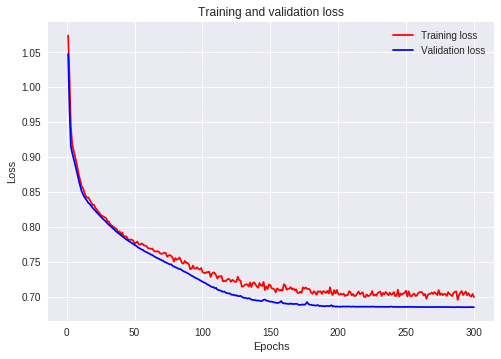

In [58]:
loss = model_basic_1hot_trained.history['loss']
val_loss = model_basic_1hot_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

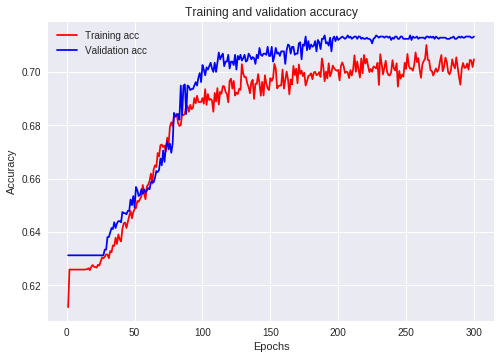

In [59]:
plt.clf()
acc = model_basic_1hot_trained.history['categorical_accuracy']
val_acc = model_basic_1hot_trained.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model learns very slowly and reached it ceiling at 71.32% for validation set. I will use now Embeddings layer instead of 1-hot encoding to see if it can improve the score.

## Model 2 - LSTM based on self generated embeddings

In [69]:
model_basic_enc = Sequential()
model_basic_enc.add(Embedding(8209, 300, input_length=22))
model_basic_enc.add(Dropout(0.3))
model_basic_enc.add(CuDNNLSTM(100, return_sequences=False))
model_basic_enc.add(Dropout(0.2))
model_basic_enc.add(Dense(3, activation='softmax'))
optimizer = RMSprop(lr=0.0001)
model_basic_enc.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

print(model_basic_enc.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 22, 300)           2462700   
_________________________________________________________________
dropout_19 (Dropout)         (None, 22, 300)           0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 100)               160800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 303       
Total params: 2,623,803
Trainable params: 2,623,803
Non-trainable params: 0
_________________________________________________________________
None


In [70]:
def scheduler(epoch):
    if epoch == 30:
        K.set_value(model_basic_enc.optimizer.lr, .00001)
    if epoch == 200:
        K.set_value(model_basic_enc.optimizer.lr, .000001)
    return K.get_value(model_basic_enc.optimizer.lr)

print('Train...')


checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/LSTM2-embeddings.hdf5', monitor="val_categorical_accuracy", save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=50)
change_lr = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early_stopping, change_lr]

model_basic_enc_trained=model_basic_enc.fit(trainX_DL, 
                                            trainY_DL, 
                                            batch_size=16, 
                                            callbacks=callbacks_list,                      
                                            epochs=500, 
                                            validation_data=(valX_DL, valY_DL), 
                                            verbose=2)

Train...
Train on 9369 samples, validate on 2343 samples
Epoch 1/500
 - 8s - loss: 0.8612 - categorical_accuracy: 0.6366 - val_loss: 0.7800 - val_categorical_accuracy: 0.6603

Epoch 00001: val_categorical_accuracy improved from -inf to 0.66026, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM2-embeddings.hdf5
Epoch 2/500
 - 6s - loss: 0.7320 - categorical_accuracy: 0.6708 - val_loss: 0.6841 - val_categorical_accuracy: 0.7102

Epoch 00002: val_categorical_accuracy improved from 0.66026 to 0.71020, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM2-embeddings.hdf5
Epoch 3/500
 - 6s - loss: 0.6523 - categorical_accuracy: 0.7267 - val_loss: 0.6248 - val_categorical_accuracy: 0.7388

Epoch 00003: val_categorical_accuracy improved from 0.71020 to 0.73880, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM2-embeddings.hdf5
Epoch 4/500
 - 6s - loss: 0.5984 - categorical_accuracy: 0.7543 - val_loss: 0.5903 - val_categorical_accuracy: 0.7576

Epoch 00004: val_

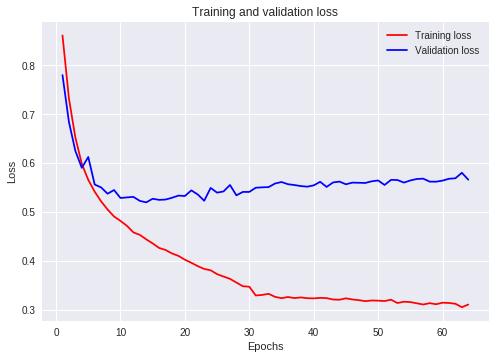

In [72]:
loss = model_basic_enc_trained.history['loss']
val_loss = model_basic_enc_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

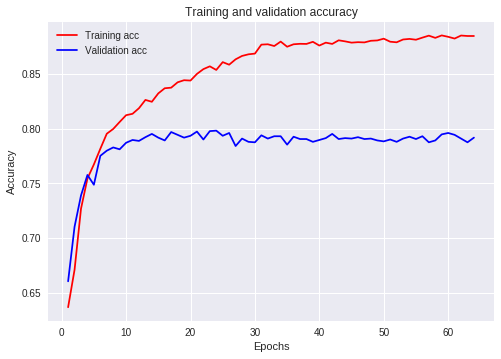

In [73]:
plt.clf()
acc = model_basic_enc_trained.history['categorical_accuracy']
val_acc = model_basic_enc_trained.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The LSTM trained using embeddings improved in comparison to first 1-hot encoded LSTM model.
The validation accuracy equals now 79.81%. This model however strongly overfits to training, using different dropout, LSTM cell sizes did not help me with reducing this effect.
I will check LSTM using pre-trained word2vec weights now.

## Model 3 - LSTM based on pretrained embeddings trained in twitter400 dataset

In [83]:
model_twitter = Sequential()
model_twitter.add(embedding_layer_twitter_pr)
model_twitter.add(Dropout(0.3))
model_twitter.add(CuDNNLSTM(100, return_sequences=False))
model_twitter.add(Dropout(0.2))
model_twitter.add(Dense(3, activation='softmax'))
optimizer = RMSprop(lr=0.0001)
model_twitter.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

print(model_twitter.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 22, 400)           3283600   
_________________________________________________________________
dropout_29 (Dropout)         (None, 22, 400)           0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 100)               200800    
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 303       
Total params: 3,484,703
Trainable params: 201,103
Non-trainable params: 3,283,600
_________________________________________________________________
None


In [84]:
def scheduler(epoch):
    if epoch == 20:
        K.set_value(model_twitter.optimizer.lr, .00001)
    if epoch == 100:
        K.set_value(model_twitter.optimizer.lr, .000001)
    return K.get_value(model_twitter.optimizer.lr)

print('Train...')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/LSTM3-embeddings.hdf5', monitor="val_categorical_accuracy", save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=50)
change_lr = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early_stopping, change_lr]

model_twitter_trained=model_twitter.fit(trainX_DL, 
                                        trainY_DL, 
                                        batch_size=16,
                                        callbacks=callbacks_list,                      
                                        epochs=500,                       
                                        validation_data=(valX_DL, valY_DL), 
                                        verbose=2)


Train...
Train on 9369 samples, validate on 2343 samples
Epoch 1/500
 - 8s - loss: 0.7633 - categorical_accuracy: 0.6830 - val_loss: 0.6421 - val_categorical_accuracy: 0.7512

Epoch 00001: val_categorical_accuracy improved from -inf to 0.75117, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM3-embeddings.hdf5
Epoch 2/500
 - 5s - loss: 0.6233 - categorical_accuracy: 0.7573 - val_loss: 0.5743 - val_categorical_accuracy: 0.7678

Epoch 00002: val_categorical_accuracy improved from 0.75117 to 0.76782, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM3-embeddings.hdf5
Epoch 3/500
 - 5s - loss: 0.5823 - categorical_accuracy: 0.7620 - val_loss: 0.5518 - val_categorical_accuracy: 0.7772

Epoch 00003: val_categorical_accuracy improved from 0.76782 to 0.77721, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM3-embeddings.hdf5
Epoch 4/500
 - 5s - loss: 0.5613 - categorical_accuracy: 0.7687 - val_loss: 0.5388 - val_categorical_accuracy: 0.7810

Epoch 00004: val_

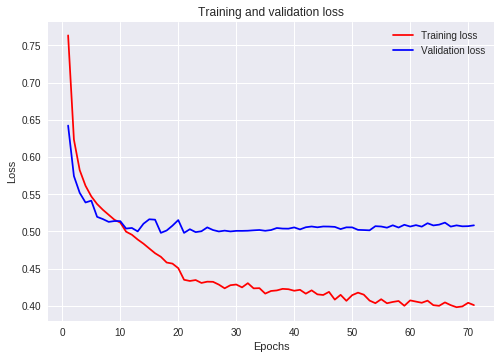

In [85]:
loss = model_twitter_trained.history['loss']
val_loss = model_twitter_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

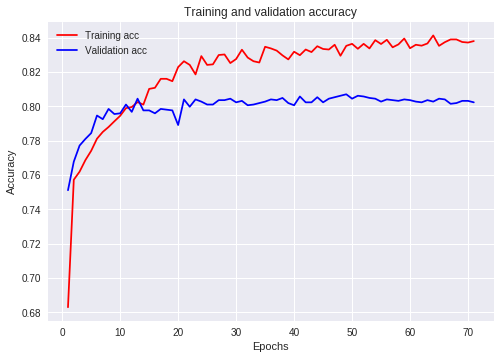

In [86]:
plt.clf()
acc = model_twitter_trained.history['categorical_accuracy']
val_acc = model_twitter_trained.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The best score now equals to **80.71%**. I gained 2.5% percents over ML models' best score.
I tried to experiment with differnt Dropout values, LSTM cell size and Learning Rate scheduler to get longer learning rates to decrease overfitting. However my attempts were not sucessful in this case. I also decided to stack additional LSTM layers, which allow me maybe to better fit to data. On the other hand I decreased the LSTM cells complexity hoping to have better generalization power of the model.

In [101]:
model_twitter_alt = Sequential()
model_twitter_alt.add(embedding_layer_twitter_pr)
model_twitter_alt.add(Dropout(0.4))
model_twitter_alt.add(CuDNNLSTM(50, return_sequences=True)) # I decreased the cell number, but created two layers. 
model_twitter_alt.add(Dropout(0.4))
model_twitter_alt.add(CuDNNLSTM(50, return_sequences=False))
model_twitter_alt.add(Dropout(0.2))
model_twitter_alt.add(Dense(3, activation='softmax'))
optimizer = RMSprop(lr=0.0001)
model_twitter_alt.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

print(model_twitter_alt.summary())

def scheduler(epoch):
    if epoch == 20:
        K.set_value(model_twitter_alt.optimizer.lr, .00001)
    if epoch == 100:
        K.set_value(model_twitter_alt.optimizer.lr, .000001)
    return K.get_value(model_twitter_alt.optimizer.lr)

print('Train...')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/LSTM3_alt_embeddings.hdf5', monitor="val_categorical_accuracy", save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=20)
change_lr = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early_stopping, change_lr]

model_twitter_alt_trained=model_twitter_alt.fit(trainX_DL, 
                                                trainY_DL, 
                                                batch_size=16,
                                                callbacks=callbacks_list,                      
                                                epochs=500,                       
                                                validation_data=(valX_DL, valY_DL, 
                                                verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 22, 400)           3283600   
_________________________________________________________________
dropout_52 (Dropout)         (None, 22, 400)           0         
_________________________________________________________________
cu_dnnlstm_33 (CuDNNLSTM)    (None, 22, 50)            90400     
_________________________________________________________________
dropout_53 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
cu_dnnlstm_34 (CuDNNLSTM)    (None, 50)                20400     
_________________________________________________________________
dropout_54 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 153       
Total para

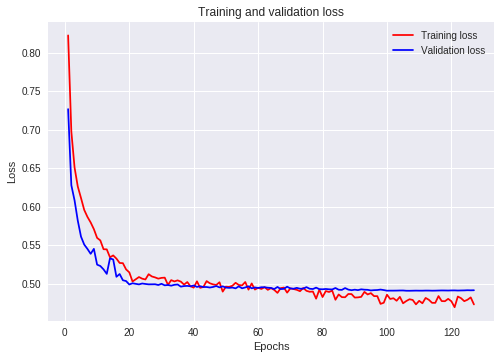

In [102]:
loss = model_twitter_alt_trained.history['loss']
val_loss = model_twitter_alt_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

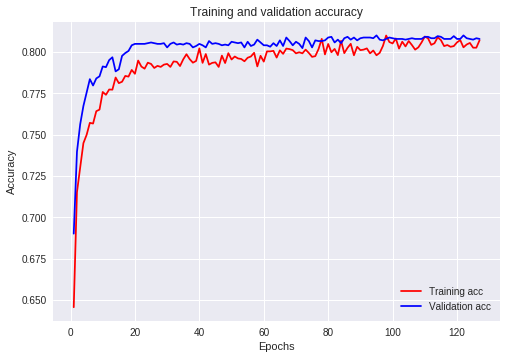

In [103]:
plt.clf()
acc = model_twitter_alt_trained.history['categorical_accuracy']
val_acc = model_twitter_alt_trained.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

My new score is **81.01%** ! The level of overfitting is much lower here. The model looks good and reliable.
Now I check how the pretrained google embeddings works.

## Model 4 - LSTM based on pretrained embeddings trained on google news300 dataset

In [35]:
model_google = Sequential()
model_google.add(embedding_layer_google_pr)
model_google.add(Dropout(0.3))
model_google.add(CuDNNLSTM(100, return_sequences=False))
model_google.add(Dropout(0.2))
model_google.add(Dense(3, activation='softmax'))
optimizer = RMSprop(lr=0.0001)
model_google.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

print(model_google.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 22, 300)           2462700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 300)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               160800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 2,623,803
Trainable params: 161,103
Non-trainable params: 2,462,700
_____

In [37]:
def scheduler(epoch):
    if epoch == 20:
        K.set_value(model_google.optimizer.lr, .00001)
    if epoch == 100:
        K.set_value(model_google.optimizer.lr, .000001)
    return K.get_value(model_google.optimizer.lr)

print('Train...')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/LSTM4-embeddings.hdf5', monitor="val_categorical_accuracy", save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=20)
change_lr = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early_stopping, change_lr]

model_google_trained=model_google.fit(trainX_DL, 
                                      trainY_DL, 
                                      batch_size=16,
                                      callbacks=callbacks_list,                      
                                      epochs=500, 
                                      validation_data=(valX_DL, valY_DL), 
                                      verbose=2)

Train...
Instructions for updating:
Use tf.cast instead.
Train on 9369 samples, validate on 2343 samples
Epoch 1/500
 - 9s - loss: 0.7990 - categorical_accuracy: 0.6508 - val_loss: 0.6821 - val_categorical_accuracy: 0.7311

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73111, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM4-embeddings.hdf5
Epoch 2/500
 - 5s - loss: 0.6544 - categorical_accuracy: 0.7359 - val_loss: 0.6067 - val_categorical_accuracy: 0.7601

Epoch 00002: val_categorical_accuracy improved from 0.73111 to 0.76014, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM4-embeddings.hdf5
Epoch 3/500
 - 5s - loss: 0.6081 - categorical_accuracy: 0.7533 - val_loss: 0.5789 - val_categorical_accuracy: 0.7657

Epoch 00003: val_categorical_accuracy improved from 0.76014 to 0.76569, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM4-embeddings.hdf5
Epoch 4/500
 - 5s - loss: 0.5844 - categorical_accuracy: 0.7630 - val_loss: 0.5624 - val

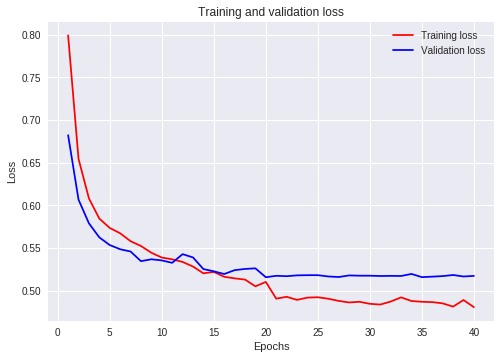

In [38]:
loss = model_google_trained.history['loss']
val_loss = model_google_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

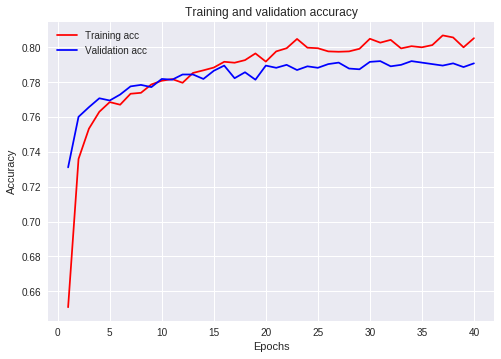

In [39]:
plt.clf()
acc = model_google_trained.history['categorical_accuracy']
val_acc = model_google_trained.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It looks like best LSTM model is achieved by twitter-pretrained embeddings (similarly as ML models score). 
Google embeddings seem to provide slightly worse result.
Now I will try to use the combination of LSTM and CNN. The CNN-LSTM are commonly used for the sequence of images use cases.
However I have seen online, the approaches for CNN-LSTM classification based on text sequences.
The intuition behind is that the convolution layer 
is able to extract better local features using Max Pooling then representing them via Embedding Layer. 

## Model 5 - CNN-LSTM based on pretrained embeddings trained on twitter400 dataset

In [42]:
model_twitter_CNN = Sequential()
model_twitter_CNN.add(embedding_layer_twitter_pr)
model_twitter_CNN.add(Dropout(0.3))
model_twitter_CNN.add(Conv1D(filters=24, kernel_size=2, padding='same', activation='relu'))
model_twitter_CNN.add(MaxPooling1D(pool_size=2))
model_twitter_CNN.add(Dropout(0.3))
model_twitter_CNN.add(CuDNNLSTM(16))
model_twitter_CNN.add(Dropout(0.2))
model_twitter_CNN.add(Dense(3, activation='softmax'))
optimizer = RMSprop(lr=0.0001)
model_twitter_CNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
print(model_twitter_CNN.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 400)           3283600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 400)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 24)            19224     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 24)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 11, 24)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 16)                2688      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
__________

In [43]:
def scheduler(epoch):
    if epoch == 50:
        K.set_value(model_twitter_CNN.optimizer.lr, .00001)
    if epoch == 200:
        K.set_value(model_twitter_CNN.optimizer.lr, .000001)
    return K.get_value(model_twitter_CNN.optimizer.lr)

print('Train...')
#with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:


checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/LSTM5-embeddings.hdf5', monitor="val_categorical_accuracy", save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=20)
change_lr = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, early_stopping, change_lr]

model_twitter_CNN_trained=model_twitter_CNN.fit(trainX_DL, 
                                                trainY_DL, 
                                                batch_size=16,
                                                callbacks=callbacks_list,                      
                                                epochs=500,                       
                                                validation_data=(valX_DL, valY_DL), 
                                                verbose=2)

Train...
Train on 9369 samples, validate on 2343 samples
Epoch 1/500
 - 5s - loss: 0.8781 - categorical_accuracy: 0.6213 - val_loss: 0.8041 - val_categorical_accuracy: 0.6500

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65002, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM5-embeddings.hdf5
Epoch 2/500
 - 4s - loss: 0.7974 - categorical_accuracy: 0.6579 - val_loss: 0.7194 - val_categorical_accuracy: 0.7051

Epoch 00002: val_categorical_accuracy improved from 0.65002 to 0.70508, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM5-embeddings.hdf5
Epoch 3/500
 - 4s - loss: 0.7381 - categorical_accuracy: 0.6992 - val_loss: 0.6518 - val_categorical_accuracy: 0.7482

Epoch 00003: val_categorical_accuracy improved from 0.70508 to 0.74819, saving model to /content/gdrive/My Drive/Colab Notebooks/LSTM5-embeddings.hdf5
Epoch 4/500
 - 4s - loss: 0.6889 - categorical_accuracy: 0.7231 - val_loss: 0.6138 - val_categorical_accuracy: 0.7606

Epoch 00004: val_

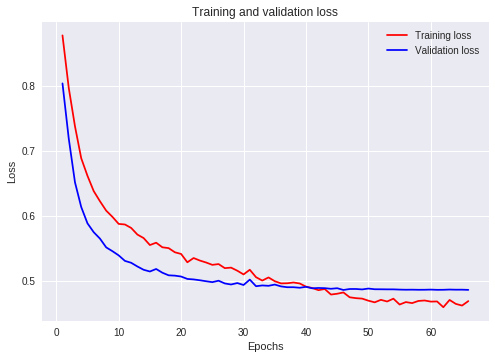

In [44]:
loss = model_twitter_CNN_trained.history['loss']
val_loss = model_twitter_CNN_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

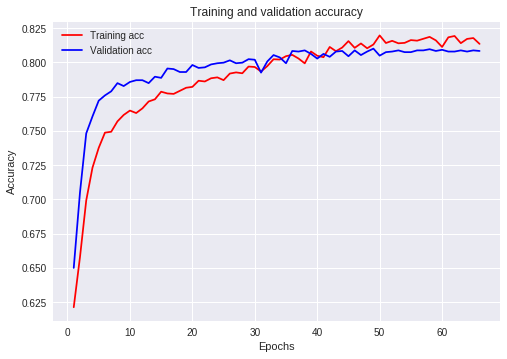

In [45]:
plt.clf()
acc = model_twitter_CNN_trained.history['categorical_accuracy']
val_acc = model_twitter_CNN_trained.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

CNN-LSTM architecture reached exactly the same accuracy as my 2-layer LSTM model :).
For prediction on the test set I will use the LSTM model from point 2.3.

## Prediction done on test set using best LSTM 

In [0]:
#  Load weights
model=keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/LSTM3_alt_embeddings.hdf5')
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])

In [0]:
# make predictions
yhat = model.predict(x_test_seq_pad, verbose=0)

In [0]:
#Define normlized confusion matrix plot

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    #plt.grid('off')
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.grid(False)
    return ax


Normalized confusion matrix
[[0.850361 0.242086 0.125828]
 [0.111971 0.651769 0.143488]
 [0.037668 0.106145 0.730684]]

Accuracy score: 0.7954234972677595


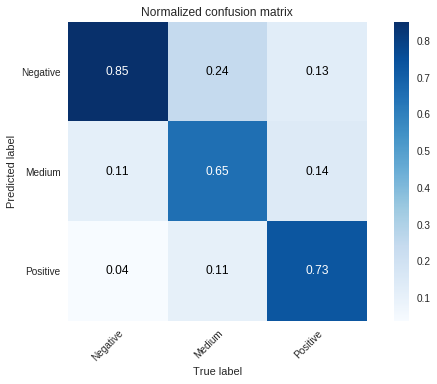

In [109]:
plot_confusion_matrix(Y_test.tolist(), np.argmax(yhat,axis=1).tolist(), classes=['Negative','Medium','Positive'], normalize=True,
                      title='Normalized confusion matrix')
print()
print('Accuracy score:',accuracy_score(Y_test.tolist(), np.argmax(yhat,axis=1).tolist()))
None

Looking at the test sample my prediction increased from 78.2% (ML model) to **79.5%** (LSTM model). On validation I reached a bit more, which means I could slighly overfit to validation sample choosing different LSTM parameters. I expected a bit more but almost 1.5% improvement might be also considered as going into good direction.
Now I move to ULMFIT modelling.

# Modelling - Deep Learning - ULMFIT

## ULMFIT 1 - learned on cleaned by me twitter text

After experimenting with LSTM models and reaching 79.5% accuracy, I move to ULMFIT.

Watching fast.ai videos and reading forum a bit I try to understand how ULMFIT works.
I understand its processing is divided into two main steps:
* Language Model Tuning - here the language model trained on wikipedia is fine-tuned on my data
  * Slanted Triangular Learning Rates - the changing learning rate should dynamically adjust to learning process. 
    The algorithm quickly converges to searched optimization local area (increasing Learning Rate) and then algortihm tries to find optimum there in this region doing it slower (decreasing Learning Rate).
  * Discriminative Fine-Tuning - Learning rate is varied across hidden layers as they represent other information and require other learning process pace.
* Classifier Tuning - here I take my Language Model network, put my softmax layer for sentiment classification instead of language model classification (in simple terms).
  * Concat Pooling - I take maxpooling and averagepooling and use them together to screen words in sequences.
  * BPT3C - BPTT extension to capture not the fixed size chunks but the whole tweet.
  * Gradual Unfreezing - Instead of learning everything at once, we teach gradually the hidden layers to preserve the benefit of wikipedia pretraining structure in the network.

<br>Quite a lot  to grasp :), happy to learn more further. </br>

Having not much experience with this kind of model I do not have specified expectations. Intuition tells me that:
* The model during a few epochs will achieve the 80% as I did in LSTM  for dozens of epochs.
* I am not sure if for my shallow vocabulary and small dataset, the multi layer hidden weights transfer learning will show its full potential, therefore I do not expect huge jump in accuracy.

Mostly I follow the Jeremy's IMDB example.


### Prepare the dataset

In [25]:
# Install the libraries
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 27kB/s 


In [26]:
# I converrt data frame to suggeted structure Labels, Texts
# I take the previously defined train sample.

train_ULMFIT = Y_train.to_frame().merge(pd.DataFrame(X_train['cleaned_text_joined']), left_index=True, right_index=True)
train_ULMFIT.columns=['labels','text']
train_ULMFIT.shape


(11712, 2)

In [27]:
train_ULMFIT.head(5)

,labels,text
4058,2,amaze fly mile unitedairlines amp alliance las...
382,1,need receipt flight change send one
1668,2,finally make rep solve problem
3766,1,southwest u mechanical problem least give u ro...
12677,0,airport extra night hotel heard anything embar...


In [0]:
# I  split the training into train and validation again.
# As I do not fully know what is done under the hood I do not want to overfit to test set with chosen hyper-parameters.
# I keep test set aside and compare model results against validation set.

train_ULMFIT_, val_ULMFIT_ = train_test_split(train_ULMFIT, 
                                              test_size = 0.2, 
                                              random_state = 88)

In [29]:
train_ULMFIT_.shape,val_ULMFIT_.shape

((9369, 2), (2343, 2))

In [30]:
train_ULMFIT_.head()

,labels,text
9119,0,pretty sure actually take
1921,1,de ice tax maybe makestoomuchsense shouldhavef...
1809,0,biz day calendar respond inquiry hope standard...
5928,0,pricing cache book flight refresh page amp pri...
3721,0,vegan meal creative noodle pea zukes non vegan...


### Fine-tuning language model

I use the TextLMDataBunch method which do the tokenization under the hood. I input my conseratively cleaned tweet text for this function.

In [224]:
# Language model data
data_lm = TextLMDataBunch.from_df('./', train_ULMFIT_,val_ULMFIT_)
data_lm

TextLMDataBunch;

Train: LabelList (9369 items)
x: LMTextList
xxbos pretty sure actually take,xxbos de ice tax maybe xxunk shouldhaveflowndelta unitedsucks,xxbos biz day calendar respond inquiry hope standard xxunk adopt badcustomerservice,xxbos pricing cache book flight refresh page amp price jumped ridiculous,xxbos vegan meal creative xxunk xxunk xxunk non vegan xxunk acceptable vegan well
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2343 items)
x: LMTextList
xxbos new ceo seek right balance please passenger wall xxunk daily xxunk,xxbos oh get ticket,xxbos xxunk aa take hr call back end pay extra statement true,xxbos please explain cost almost price full roundtrip fair change departure time flight,xxbos except wait time phone system hang continue hold help
y: LMLabelList
,,,,
Path: .;

Test: None

In [225]:
# Vocabulary - first 20 words
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'flight',
 'get',
 'hour',
 'u',
 'thanks',
 'cancel',
 'time',
 'service',
 'help',
 'customer',
 'call',
 'go']

We can see here the new tags specified by fast.ai tokenizer:
* xxbos: begining of a sentence
* xxfld: separate parts of a document 
* xxup: capitalization
* xxunk: uncommon words
* xxmaj: first letter up
* xxrep: reapeated characters

In [226]:
len(data_lm.vocab.itos)

3635

In [227]:
learn1 = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn1.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,8.359239,7.090025,0.042336,00:07


In [228]:
learn1.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


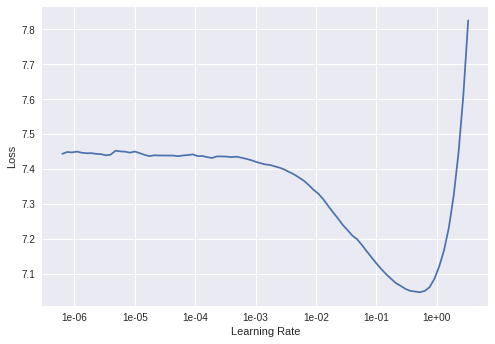

In [229]:
learn1.recorder.plot()

Here is my learning rate for language model which adapsts the idea of "Cyclical Learning Rates".
Having my learning rate I learn 1 epoch of my language model choosing such rate which still drops the learning rate value but is enough distance to minimum (here 1e-02).

In [230]:
learn1.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) #1e-2 looks like good choice, learning rate is decreasing and still not the closest to minimum

epoch,train_loss,valid_loss,accuracy,time
1,6.871571,6.181429,0.104278,00:07


I unfreeze whole network and learn 5 epochs (later it does not improve)

In [231]:
learn1.unfreeze()
learn1.fit_one_cycle(5, 5e-3, moms=(0.8,0.7)) #let's get a bit further from the minimum with learning rate (5e-3)

epoch,train_loss,valid_loss,accuracy,time
1,6.267880,5.848715,0.138690,00:09
2,6.194613,5.689003,0.152195,00:09
3,5.944240,5.548275,0.161719,00:09
4,5.705519,5.517415,0.162574,00:09
5,5.509694,5.527777,0.162909,00:09


In [0]:
# Save learning model.
learn1.save('fine_tuned')
learn1.save_encoder('fine_tuned_enc') # this encoder is used for classification tuning

### Fine-tuning classification model

In [233]:
# Similarly as previously, I create the object of tokenized words + this time also having my Y response vector ready for classification.

data_clas = TextClasDataBunch.from_df('./', train_ULMFIT_,val_ULMFIT_, vocab=data_lm.train_ds.vocab, bs=32)
data_clas

TextClasDataBunch;

Train: LabelList (9369 items)
x: TextList
xxbos pretty sure actually take,xxbos de ice tax maybe xxunk shouldhaveflowndelta unitedsucks,xxbos biz day calendar respond inquiry hope standard xxunk adopt badcustomerservice,xxbos pricing cache book flight refresh page amp price jumped ridiculous,xxbos vegan meal creative xxunk xxunk xxunk non vegan xxunk acceptable vegan well
y: CategoryList
0,1,0,0,0
Path: .;

Valid: LabelList (2343 items)
x: TextList
xxbos new ceo seek right balance please passenger wall xxunk daily xxunk,xxbos oh get ticket,xxbos xxunk aa take hr call back end pay extra statement true,xxbos please explain cost almost price full roundtrip fair change departure time flight,xxbos except wait time phone system hang continue hold help
y: CategoryList
1,1,0,0,0
Path: .;

Test: None

In [234]:
data_clas.show_batch()

text,target
xxbos rude cust xxunk agent busy chat yell bc take pic put xxunk seat diff agent give seat min late flightr platinum,0
xxbos delayed hr flight pit iad finally board plane sit half hour amp crew hr limit amp deplane unacceptable,0
xxbos i m try call book reward ticket one world partner automate system wo nt let talk great job,0
xxbos basically need leave hawaii late flight even midnight get back philly late flight monday night trip get tues,1
xxbos hr tarmac yest b cancel flight today hr delay send txt email jfk close amp save trip sit,0


In [0]:
# Let's see the structure of the model
learn1 = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn1.load_encoder('fine_tuned_enc')

In [236]:
list(learn1.model.children())

[MultiBatchEncoder(
   (module): AWD_LSTM(
     (encoder): Embedding(3635, 400, padding_idx=1)
     (encoder_dp): EmbeddingDropout(
       (emb): Embedding(3635, 400, padding_idx=1)
     )
     (rnns): ModuleList(
       (0): WeightDropout(
         (module): LSTM(400, 1150, batch_first=True)
       )
       (1): WeightDropout(
         (module): LSTM(1150, 1150, batch_first=True)
       )
       (2): WeightDropout(
         (module): LSTM(1150, 400, batch_first=True)
       )
     )
     (input_dp): RNNDropout()
     (hidden_dps): ModuleList(
       (0): RNNDropout()
       (1): RNNDropout()
       (2): RNNDropout()
     )
   )
 ), PoolingLinearClassifier(
   (layers): Sequential(
     (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (1): Dropout(p=0.2)
     (2): Linear(in_features=1200, out_features=50, bias=True)
     (3): ReLU(inplace)
     (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): Dropo

Quite complex architecture for me. Need study a bit to understand it. The architecture looks as follows:

* Embedding layer trained on wikitext103 and fine tuned in language model stage. (it should be similar to Word2vec learned on wikipedia available on _gensim_ website).
* Three-layer LSTM  cells trained on wikitext again and tuned in previous step. (In LSTM section I stacked maximum 2 layers).
* Two linear layers to transform high dimensions to number of prediction classes. (similar to dense I think).
A lot of regularization happens here including dropouts and batch normalization.

In [237]:
# Looking for Learning rate for the classification model
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


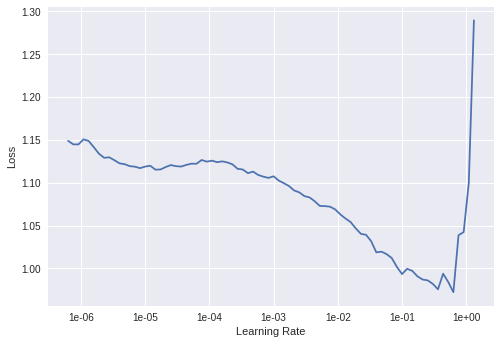

In [238]:
learn1.recorder.plot()

In [239]:
#Applying gradual unfreezing for the tuning process
learn1.fit_one_cycle(1, 1e-2)
learn1.save('first')

epoch,train_loss,valid_loss,accuracy,time
1,0.773841,0.611324,0.743918,00:10


In [240]:
learn1.load('first');
learn1.freeze_to(-2)
learn1.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))
learn1.save('second')

epoch,train_loss,valid_loss,accuracy,time
1,0.690841,0.586456,0.758429,00:12


In [241]:
learn1.load('second')
learn1.freeze_to(-3)
learn1.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn1.save('third')

epoch,train_loss,valid_loss,accuracy,time
1,0.638488,0.573238,0.772514,00:19


In [242]:
learn1.load('third');
learn1.unfreeze()
learn1.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn1, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,time
1,0.649485,0.560210,0.771660,00:24
2,0.597899,0.517203,0.791293,00:25
3,0.556742,0.518161,0.799829,00:24
4,0.491365,0.502915,0.799829,00:24
5,0.464773,0.497091,0.808365,00:24


Better model found at epoch 1 with accuracy value: 0.7716602683067322.
Better model found at epoch 2 with accuracy value: 0.791293203830719.
Better model found at epoch 3 with accuracy value: 0.7998293042182922.
Better model found at epoch 5 with accuracy value: 0.8083653450012207.


I did not train the model further (it produced massive overfitting). Setting different parameters of fit_one_cycle function did not improved the overfitting issue. I would need to optimize these parameters (wd, slice momentum) in some way, but now I do not have the tools to do it.
So I consider that this is not tuned ULMFIT model. Almost 81% on validation looks promising.
Now I will test this model against the test set.

### Test set accuracy

In [243]:
# Prepare the test set in specific format (labels, text)
test_ULMFIT = Y_test.to_frame().merge(pd.DataFrame(X_test['cleaned_text_joined']), left_index=True, right_index=True)
test_ULMFIT.columns=['labels','text']
test_ULMFIT.shape


(2928, 2)

In [244]:
test_ULMFIT.head(10)

,labels,text
1022,2,soon do article thanks tom
11109,2,lol
682,0,luckily make flight time disappointed lack com...
9981,0,cancel flight every flight
13686,0,word failure mean act instance fail prove unsu...
13568,0,try reach american airline since last even can...
13363,0,get travel question answer quickly online call...
13138,2,thank help p guy best americanairlines america...
12291,1,forgot select ksml flight la minute hour mark ...
7757,0,hey jetblue strand entire plane suppose go jfk...


In [0]:
# Read the best model from 10 I have learned
learn1.load('best')
None

In [4]:
# Predict the using 'text' column
test_ULMFIT['Prediction'] = test_ULMFIT['text'].apply(lambda row: str(learn1.predict(row)[0]))


NameError: name 'test_ULMFIT' is not defined

In [247]:
test_ULMFIT.head(10)

,labels,text,Prediction
1022,2,soon do article thanks tom,2
11109,2,lol,2
682,0,luckily make flight time disappointed lack com...,0
9981,0,cancel flight every flight,0
13686,0,word failure mean act instance fail prove unsu...,0
13568,0,try reach american airline since last even can...,0
13363,0,get travel question answer quickly online call...,0
13138,2,thank help p guy best americanairlines america...,2
12291,1,forgot select ksml flight la minute hour mark ...,0
7757,0,hey jetblue strand entire plane suppose go jfk...,0


Normalized confusion matrix
[[0.84     0.236515 0.091928]
 [0.123    0.659751 0.152466]
 [0.037    0.103734 0.755605]]

Accuracy score: 0.7974726775956285


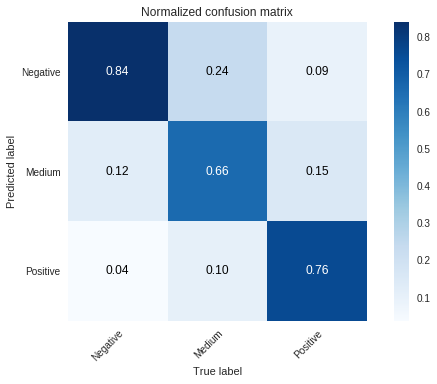

In [248]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_ULMFIT['labels'].astype(int), test_ULMFIT['Prediction'].astype(int), classes=['Negative','Medium','Positive'], normalize=True,
                      title='Normalized confusion matrix')
print()
print('Accuracy score:',accuracy_score(test_ULMFIT['labels'].astype(int), test_ULMFIT['Prediction'].astype(int)))
None

I reached with ULMfit (**79.74%**) similar accuracy to my best LSTM network (**79.54%**). Quite good result which is achievable in first 5 epochs.
Probably with this way of preparing the twitter text data, I reached the ceiling of predictive power. I end here the search of an optimal algorithm. So far I got the following scores checked on 20% test sample:
* Best Machine Learning Algorithm - Logistic regression (twitter pretrained embeddings) found by TPOT - 78.2% 
* Best LSTM network (2 hidden layers, unidirectional, 50 unit LSTM) - 79.54%
* UMLFIT - 79.74% 

As next step I will try to change my X matrix (twitter text) so that it better captures semantic characteristics, 
I will use ULMFIT for next experiments as I get very good results very quickly training a few epochs only. 

##  ULMFIT 2 - Changing the cleaning of the twitter text

Instead of cleaning twitter text in classical NLP way (lower cases, lemmatization etc. ) I will use fast.ai tokenizer. I used it before in previous section, but I used it on text which has been preprocessed before using clean_text_full function. Due to that, I probably lost some meaningful piece of information. Now I will use lighter cleansing approach, removing the twitter user and https only. Then applying fast.ai tokenizer.

### Prepare the dataset

In [0]:
def clean_tweets_light(tweet):
    # remove the owner
    tweet = re.sub(r'@[A-Za-z0-9]+','', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    return tweet

In [0]:
df_tweet['text_ulmfit2']=df_tweet['text']

In [0]:
X_train_ULMFIT2, X_test_ULMFIT2, Y_train_ULMFIT2, Y_test_ULMFIT2 = train_test_split(df_tweet['text'].apply(lambda x: clean_tweets_light(x)), df_tweet['airline_sentiment'].astype('category').cat.codes, test_size=0.2, random_state=88)

In [49]:
X_train_ULMFIT2.shape, X_test_ULMFIT2.shape

((11712,), (2928,))

In [50]:
# Show exemplary tweets - cleaned lightly
pd.set_option('display.max_colwidth', -1)
train_ULMFIT2 = Y_train_ULMFIT2.to_frame().merge(pd.DataFrame(X_train_ULMFIT2), left_index=True, right_index=True)
train_ULMFIT2.columns=['labels','text']
print(f'Shape : {train_ULMFIT2.shape}')
train_ULMFIT2.sample(5)

Shape : (11712, 2)


,labels,text
6117,2,thank u for not leaving me \n nice job running thru the airport to catch your connecting flight
4332,0,your agents were the ones who were rude and unhelpful and prompted my initial tweet. This is so easy to fix.
2353,0,who is in charge of making decisions over there? Cancelled Flightling flight UA1150 was unacceptable. I should be in #Belize right now.
6408,0,you're 4/4 on blowing it with your customer service. Shotwest Airlines.
5839,1,please reply to my DM ♥️


The texts looks much wealthier now.

In [0]:
# Split the training into training and validation
train_ULMFIT2_, val_ULMFIT2_ = train_test_split(train_ULMFIT2, 
                                                test_size = 0.2, 
                                                random_state = 88)


In [52]:
train_ULMFIT2_.shape

(9369, 2)

### Fine-tuning language model

In [262]:
# Tokenize the words for LM
data_lm2 = TextLMDataBunch.from_df('./', train_ULMFIT2_,val_ULMFIT2_)
data_lm2

TextLMDataBunch;

Train: LabelList (9369 items)
x: LMTextList
xxbos pretty sure we did n't actually take off at xxunk,xxbos why de - ice before taxing ? xxmaj maybe it # xxunk ? # shouldhaveflowndelta # unitedsucks,xxbos xxmaj only 14 biz days ( 18 calendar ) to respond to my xxunk ? i hope your standards are xxunk adopted : - / # badcustomerservice,xxbos xxmaj what 's with the pricing xxunk ? ! xxmaj about to book a flight , refreshed the page , & & the price jumped from $ 73 to $ xxunk . xxmaj ridiculous . 😑,xxbos # vegan meals can be more creative than xxunk , xxunk , and xxunk . xxmaj non - vegan xxunk is not acceptable for a vegan . xxmaj can you do better ?
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2343 items)
x: LMTextList
xxbos 's new xxup ceo seeks the right balance to please passengers and xxmaj wall ... - xxmaj xxunk xxmaj daily xxmaj xxunk,xxbos how oh how do we get tickets ! ? !,xxbos xxmaj only xxunk because aa took 2 hrs to call me back . xxmaj ended up paying ( ex

In [265]:
# Compare number of tokens between first and second data model
len(data_lm2.vocab.itos), len(data_lm.vocab.itos)

(5007, 3635)

Now we have around 1,5k more tokens to use for prediction!

In [271]:
# Fit the pretrained language model
learn2 = language_model_learner(data_lm2, AWD_LSTM, drop_mult=0.5)
learn2.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,5.482459,4.665331,0.205227,00:17


In [272]:
# Find learning rate
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


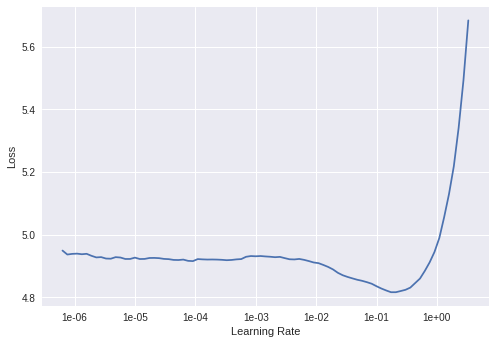

In [273]:
learn2.recorder.plot()

In [274]:
# Train further learning model
learn2.unfreeze()
learn2.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.738094,4.369100,0.226990,00:21
2,4.550375,4.166926,0.248977,00:21
3,4.358357,4.037368,0.265327,00:21
4,4.179216,3.964646,0.271447,00:21
5,4.018961,3.908320,0.277083,00:21
6,3.878852,3.881935,0.279408,00:21
7,3.753724,3.866576,0.281101,00:21
8,3.659350,3.863448,0.281771,00:21
9,3.601789,3.866054,0.281920,00:21
10,3.560535,3.865941,0.281417,00:21


Looking at the quality of language model one can notice the improvement, previously we had around 16%, now 28%.

In [0]:
learn2.save('fine_tuned2')
learn2.save_encoder('fine_tuned_enc2')

### Fine-tuning classification model

In [276]:
data_clas2 = TextClasDataBunch.from_df('./', train_ULMFIT2_,val_ULMFIT2_, vocab=data_lm2.train_ds.vocab, bs=32)
data_clas2

TextClasDataBunch;

Train: LabelList (9369 items)
x: TextList
xxbos pretty sure we did n't actually take off at xxunk,xxbos why de - ice before taxing ? xxmaj maybe it # xxunk ? # shouldhaveflowndelta # unitedsucks,xxbos xxmaj only 14 biz days ( 18 calendar ) to respond to my xxunk ? i hope your standards are xxunk adopted : - / # badcustomerservice,xxbos xxmaj what 's with the pricing xxunk ? ! xxmaj about to book a flight , refreshed the page , & & the price jumped from $ 73 to $ xxunk . xxmaj ridiculous . 😑,xxbos # vegan meals can be more creative than xxunk , xxunk , and xxunk . xxmaj non - vegan xxunk is not acceptable for a vegan . xxmaj can you do better ?
y: CategoryList
0,1,0,0,0
Path: .;

Valid: LabelList (2343 items)
x: TextList
xxbos 's new xxup ceo seeks the right balance to please passengers and xxmaj wall ... - xxmaj xxunk xxmaj daily xxmaj xxunk,xxbos how oh how do we get tickets ! ? !,xxbos xxmaj only xxunk because aa took 2 hrs to call me back . xxmaj ended up paying 

In [277]:
# Let's see the exemplary tokenized batch of tweets
data_clas2.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,2
xxbos xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup xxunk ! ! # xxup xxunk,0
"xxbos file loc : xxup xxunk . xxmaj bag at airport since last nite . xxmaj not "" scheduled "" to get xxup xxunk xxunk xxunk 8 ? xxup why ? u shld b ashamed . i 'm disgusted w / u",0
xxbos xxmaj is your xxup bwi - xxup sjd service xxunk ? xxmaj was n't part of extension . xxmaj called intl desk . xxmaj they did n't know . xxmaj want to fly in xxmaj sept on xxmaj sat .,0
"xxbos sorry for the delayed response . xxmaj it was xxup ua # xxunk xxmaj chicago to xxmaj san xxmaj fran . xxmaj held up for almost an hour on the xxmaj tarmac . xxmaj also , lost my bags",0


Here we can notice how more types of tokens exist in training column, especially the special ones in form of xxmaj, xxup and so on. We have also the emojis which might have an important role in semantic classification.

In [0]:
learn2 = text_classifier_learner(data_clas2, AWD_LSTM, drop_mult=0.5)
learn2.load_encoder('fine_tuned_enc2')

In [288]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


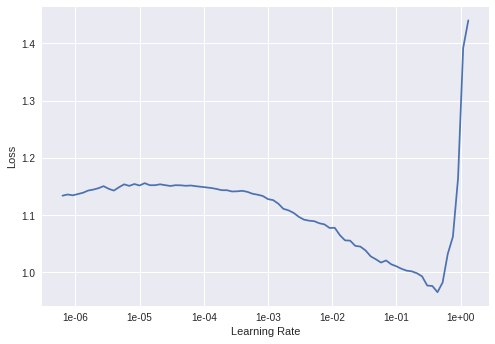

In [289]:
learn2.recorder.plot()

In [290]:
learn2.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn2.save('first2')

epoch,train_loss,valid_loss,accuracy,time
1,0.730748,0.570215,0.756722,00:19


In [291]:
learn2.load('first2');
learn2.freeze_to(-2)
learn2.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))
learn2.save('second2')

epoch,train_loss,valid_loss,accuracy,time
1,0.645903,0.517806,0.791720,00:22


In [292]:
learn2.load('second2')
learn2.freeze_to(-3)
learn2.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn2.save('third2')

epoch,train_loss,valid_loss,accuracy,time
1,0.596749,0.487471,0.807512,00:35


In [293]:
learn2.load('third2');
learn2.unfreeze()
learn2.fit_one_cycle(10, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7),callbacks=[callbacks.SaveModelCallback(learn2, every='improvement', monitor='accuracy', name='best2')])

epoch,train_loss,valid_loss,accuracy,time
1,0.556570,0.484862,0.808365,00:44
2,0.561681,0.470055,0.815621,00:44
3,0.528490,0.461279,0.818182,00:44
4,0.541219,0.454627,0.823730,00:44
5,0.507327,0.467937,0.818182,00:44
6,0.487745,0.461016,0.822023,00:44
7,0.455202,0.449329,0.827145,00:45
8,0.447676,0.452216,0.825437,00:44
9,0.436913,0.448857,0.826291,00:44
10,0.414660,0.457231,0.826291,00:44


Better model found at epoch 1 with accuracy value: 0.8083653450012207.
Better model found at epoch 2 with accuracy value: 0.815621018409729.
Better model found at epoch 3 with accuracy value: 0.8181818127632141.
Better model found at epoch 4 with accuracy value: 0.8237302899360657.
Better model found at epoch 7 with accuracy value: 0.8271446824073792.


By comparing validation scores I gained 2%! Let's check the result on the test set.

### Test set accuracy

In [92]:
# Create test set in approapraite structure
test_ULMFIT2 = Y_test_ULMFIT2.to_frame().merge(pd.DataFrame(X_test_ULMFIT2), left_index=True, right_index=True)
test_ULMFIT2.columns=['labels','text']
test_ULMFIT2.shape

(2928, 2)

In [0]:
# Read the best model
learn2.load('best2')
None

In [301]:
# Compare the test sample betweet UMLFIT1 and UMLFIT2 models
pd.set_option('display.max_colwidth', -1)
test_set_comparison=test_ULMFIT2.head(5).merge(test_ULMFIT.iloc[:,[0,1]].head(5),left_index=True, right_index=True)
test_set_comparison.columns=['labels1','text1','labels2','text2']
test_set_comparison

,labels1,text1,labels2,text2
1022,2,"I will, as soon as I am done with my article. Thanks! ~Tom",2,soon do article thanks tom
11109,2,lol me too,2,lol
682,0,Luckily I made my flights this time but was so disappointed with the lack of communication :(,0,luckily make flight time disappointed lack communication
9981,0,Just Cancelled Flight every flight I have why don't you.,0,cancel flight every flight
13686,0,The word failure means: an act or instance of failing or proving unsuccessful; lack of success nonperformance of something due.,0,word failure mean act instance fail prove unsuccessful lack success nonperformance something due


Here one can notice the difference in wealthiness between two cleansing approaches.

In [0]:
# Let's do the prediction
test_ULMFIT2['Prediction'] = test_ULMFIT2['text'].apply(lambda row: str(learn2.predict(row)[0]))


Normalized confusion matrix
[[0.867563 0.202703 0.111111]
 [0.102431 0.708494 0.140461]
 [0.030005 0.088803 0.748428]]

Accuracy score: 0.8200136612021858


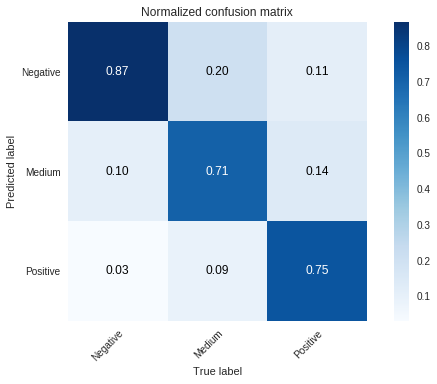

In [304]:
# Let's plot the confusion matrix
plot_confusion_matrix(test_ULMFIT2['labels'].astype(int), test_ULMFIT2['Prediction'].astype(int), classes=['Negative','Medium','Positive'], normalize=True,
                      title='Normalized confusion matrix')
print()
print('Accuracy score:',accuracy_score(test_ULMFIT2['labels'].astype(int), test_ULMFIT2['Prediction'].astype(int)))
None

Great improvement!. Now my score equals to **82%**. By abandoning classical cleansing methods and applying the fast.ai tokenizer I gained next 2%.

## ULMFIT 3 - Choosing the observation with high confidence score for analysis.

Having analysed the words in split of sentiment confidence in my EDA section in Notebook-part1, I noticed that for some cases there were significant differences of vocabulary between strong and medium confident tweets.
I think that I can select only these tweets which have very strong sentiment confidence and train the algorithm on them. They should emphasize the signals much better than all the tweets analysed together.

### Prepare the dataset

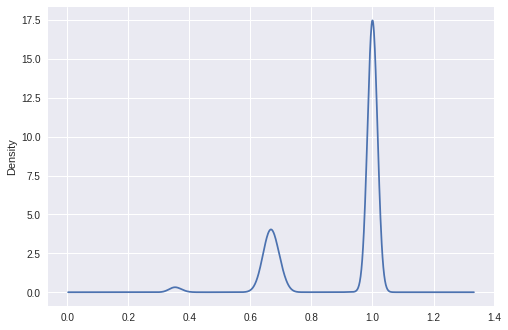

In [64]:
# Airline sentiment score
df_tweet['airline_sentiment_confidence'].plot.kde(bw_method=0.1)
None

I choose the observation with score higher than 80%.

In [65]:
# Subselect the tweets

df_tweet[(df_tweet.airline_sentiment_confidence >= 0.8)].shape

(10459, 18)

In [0]:
# Split train nad test
X_train_ULMFIT3, _ , Y_train_ULMFIT3, _ = train_test_split(df_tweet[(df_tweet.airline_sentiment_confidence >= 0.8)]['text_ulmfit2'].apply(lambda x: clean_tweets_light(x)), df_tweet[(df_tweet.airline_sentiment_confidence >= 0.8)]['airline_sentiment'].astype('category').cat.codes, test_size=0.2, random_state=88)

Here I don't create separate test sets as they are already created.

In [67]:
X_train_ULMFIT3.shape,X_test_ULMFIT2.shape

((8367,), (2928,))

In [68]:
# Show exemplary tweets - cleaned lightly and pre-selected
pd.set_option('display.max_colwidth', -1)
train_ULMFIT3 = Y_train_ULMFIT3.to_frame().merge(pd.DataFrame(X_train_ULMFIT3), left_index=True, right_index=True)
train_ULMFIT3.columns=['labels','text']
print(f'Shape : {train_ULMFIT3.shape}')
train_ULMFIT3.sample(5)

Shape : (8367, 2)


,labels,text
220,0,had to change to another airline to get to DC today ... Why is able to land in DC but not you? Cost me $800 ...ugh
7688,0,I missed a goal On because of your Inept male stewardess. I should have landed already but I havent taken off yet.
9958,1,AA Gate Supervisor emplid 600117 allowed flight AA67 to leave JFK to SJ on 20feb15 w/o 8 customers that made final boarding call.
12877,0,"not only on both legs did I have damaged seat, u damaged an expensive case and not offered anything.Just an apology 6wks Late Flightr!"
9302,0,. and then you said I could move my Thursday flight for free if I CALL A NUMBER. And then you HANG UP ON ME.


In [0]:
train_ULMFIT3_, val_ULMFIT3_ = train_test_split(train_ULMFIT3, 
                                                test_size = 0.2, 
                                                random_state = 88)

In [74]:
train_ULMFIT3_.shape, train_ULMFIT2_.shape

((6693, 2), (9369, 2))

I lost almost 3k of tweets for purpose of training due to selection based on confidence.
It is important to notice that my validation set to which I compare my accuracy during model training consists of the selected tweets (confidence >0.8), whereas my test set is my original test set consisting of all kind of tweets (also these having sentiment confidence lower than 0.8). It means that I can expect higher scores on validation but the true benchmark score will be test set prediction which should be lower than validation score.

### Fine-tuning language model

In [98]:
# Tokenize the words for LM
data_lm3 = TextLMDataBunch.from_df('./', train_ULMFIT3_,val_ULMFIT3_)
data_lm3

TextLMDataBunch;

Train: LabelList (6693 items)
x: LMTextList
xxbos it ’s just a bug report , guys,xxbos i want to give a warm thanks to your crew at xxmaj logan airport for still getting me to the xxup dc area after xxmaj cancelled xxmaj flightlations this morning !,xxbos xxmaj are you xxunk any more winners to the # destinationdragons show in xxup utah this weekend ? # xxmaj lucky,xxbos yes ! xxmaj always a treat to fly with you guys ! 😊 ✈ ️,xxbos has no idea what customer service means . xxmaj as the customer , if you mess up my plans , do n't treat me like its no big deal !
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (1674 items)
x: LMTextList
xxbos xxmaj making sure your flights are n't delayed due to poor maintenance would be a start .,xxbos misplaced my bag 36 hr ago and ca n't tell me where it is . i 've lost $ 1000 of stuff :( # americanairlines # xxunk,xxbos over 4 weeks since you took our money and left us stranded 9 hours from home . xxmaj had to rent a car and you still

In [99]:
# Fit the pretrained language model
learn3 = language_model_learner(data_lm3, AWD_LSTM, drop_mult=0.5)
learn3.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,5.614425,4.808823,0.199479,00:13


In [100]:
# Find learning rate
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


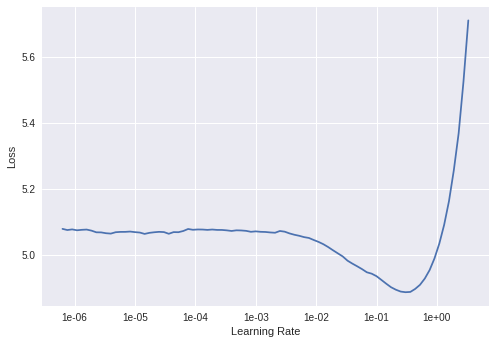

In [101]:
learn3.recorder.plot()

In [102]:
# Fine-tune the LM
learn3.unfreeze()
learn3.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.865239,4.432508,0.223413,00:16
2,4.659314,4.221804,0.244469,00:16
3,4.452980,4.059975,0.256275,00:16
4,4.260666,3.965018,0.265352,00:16
5,4.091630,3.912980,0.271974,00:16
6,3.943680,3.880371,0.275694,00:16
7,3.816028,3.865519,0.277579,00:16
8,3.712872,3.863450,0.277728,00:16
9,3.639132,3.861272,0.278547,00:16
10,3.591646,3.862769,0.278423,00:16


In [0]:
learn3.save('fine_tuned3')
learn3.save_encoder('fine_tuned_enc3')

The trained ULMFIT3 LM looks comparable to ULMFIT2 LM model in terms of accuracy.

### Fine-tuning classification model

In [104]:
# Prepare data for classification model
data_clas3 = TextClasDataBunch.from_df('./', train_ULMFIT3_,val_ULMFIT3_, vocab=data_lm3.train_ds.vocab, bs=32)
data_clas3

TextClasDataBunch;

Train: LabelList (6693 items)
x: TextList
xxbos it ’s just a bug report , guys,xxbos i want to give a warm thanks to your crew at xxmaj logan airport for still getting me to the xxup dc area after xxmaj cancelled xxmaj flightlations this morning !,xxbos xxmaj are you xxunk any more winners to the # destinationdragons show in xxup utah this weekend ? # xxmaj lucky,xxbos yes ! xxmaj always a treat to fly with you guys ! 😊 ✈ ️,xxbos has no idea what customer service means . xxmaj as the customer , if you mess up my plans , do n't treat me like its no big deal !
y: CategoryList
1,2,1,2,0
Path: .;

Valid: LabelList (1674 items)
x: TextList
xxbos xxmaj making sure your flights are n't delayed due to poor maintenance would be a start .,xxbos misplaced my bag 36 hr ago and ca n't tell me where it is . i 've lost $ 1000 of stuff :( # americanairlines # xxunk,xxbos over 4 weeks since you took our money and left us stranded 9 hours from home . xxmaj had to rent a car and you s

In [0]:
# Let's tune classification model
learn3 = text_classifier_learner(data_clas3, AWD_LSTM, drop_mult=0.5)
learn3.load_encoder('fine_tuned_enc3')

In [106]:
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


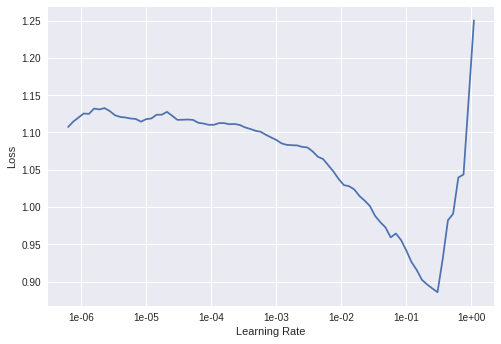

In [107]:
learn3.recorder.plot()

In [108]:
# Tuning classification model using Gradual Unfreezing
learn3.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn3.save('first3')

epoch,train_loss,valid_loss,accuracy,time
1,0.599574,0.399241,0.839307,00:14


In [109]:
learn3.load('first3');
learn3.freeze_to(-2)
learn3.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))
learn3.save('second3')

epoch,train_loss,valid_loss,accuracy,time
1,0.531623,0.349482,0.871565,00:16


In [110]:
learn3.load('second3')
learn3.freeze_to(-3)
learn3.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn3.save('third3')

epoch,train_loss,valid_loss,accuracy,time
1,0.476796,0.320753,0.887694,00:25


In [111]:
learn3.load('third3');
learn3.unfreeze()
learn3.fit_one_cycle(15, slice(1e-3/(2.6**4), 5e-4), moms=(0.8,0.7),callbacks=[callbacks.SaveModelCallback(learn3, every='improvement', monitor='accuracy', name='best3')])

epoch,train_loss,valid_loss,accuracy,time
1,0.428759,0.314168,0.892473,00:34
2,0.426104,0.314587,0.890681,00:33
3,0.427127,0.316740,0.890084,00:33
4,0.413861,0.305272,0.896057,00:32
5,0.356786,0.306943,0.894863,00:33
6,0.366104,0.297609,0.896057,00:33
7,0.351447,0.302249,0.900239,00:34
8,0.358197,0.291552,0.899642,00:33
9,0.327970,0.302614,0.899044,00:33
10,0.320382,0.304208,0.893668,00:33


Better model found at epoch 1 with accuracy value: 0.8924731016159058.
Better model found at epoch 4 with accuracy value: 0.8960573673248291.
Better model found at epoch 7 with accuracy value: 0.9002389311790466.
Better model found at epoch 13 with accuracy value: 0.9008363485336304.
Better model found at epoch 14 with accuracy value: 0.9014337062835693.


In [0]:
# Read the best model
learn3.load('best3')
None

For validation which consists only from highly confident sentiment tweets, I reached score above **90%**, nice!. Let's see the impact of my change on the test set.

### Test set accuracy

In [0]:
test_ULMFIT3=test_ULMFIT2.copy()

In [0]:
test_ULMFIT3['Prediction'] = test_ULMFIT3['text'].apply(lambda row: str(learn3.predict(row)[0]))

Normalized confusion matrix
[[0.853563 0.132867 0.088362]
 [0.114005 0.785548 0.135776]
 [0.032432 0.081585 0.775862]]

Accuracy score: 0.8312841530054644


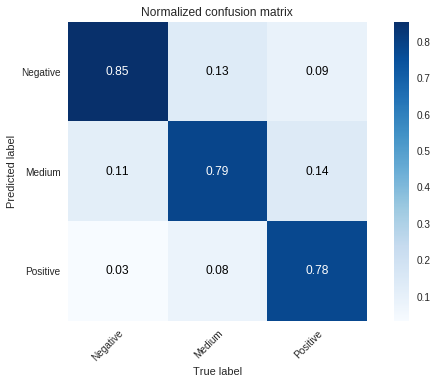

In [115]:
plot_confusion_matrix(test_ULMFIT3['labels'].astype(int), test_ULMFIT3['Prediction'].astype(int), classes=['Negative','Medium','Positive'], normalize=True,
                      title='Normalized confusion matrix')
print()
print('Accuracy score:',accuracy_score(test_ULMFIT3['labels'].astype(int), test_ULMFIT3['Prediction'].astype(int)))
None

My score increased from 82% to **83%**.. I expected a bit more.
Nevertheless this is my final score and final model.
It is also worth emphasizing that I improved the prediction for neutral and medium sentiment class and worsened a bit the score for negative class. Let's see why it happened.

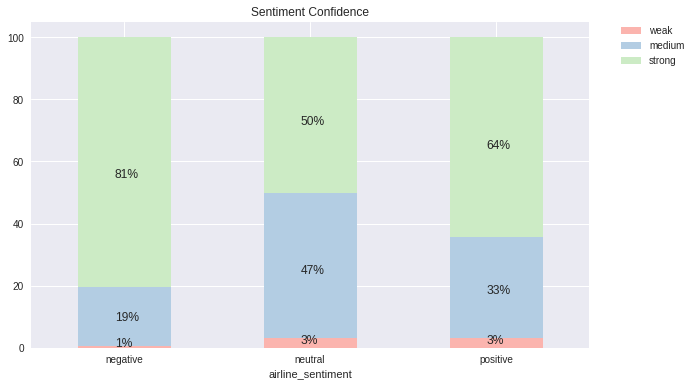

In [123]:
import seaborn as sns
custom_bucket_array = np.linspace(0.2, 1, 4)
custom_bucket_array
df_tweet['airline_sentiment_confidence_buckets'] = pd.cut(df_tweet['airline_sentiment_confidence'], custom_bucket_array, labels=["weak", "medium", "strong"])

ax = pd.crosstab(index = df_tweet["airline_sentiment"],columns = df_tweet["airline_sentiment_confidence_buckets"]).apply(lambda x: round(x / x.sum() * 100,2), axis=1).plot(kind='bar',
                                                                                                                                                                            color=sns.color_palette("Pastel1", 10),
                                                                                                                                                                            figsize=(10, 6),
                                                                                                                                                                            rot=0,
                                                                                                                                                                            stacked=True,
                                                                                                                                                                            title="Sentiment Confidence")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

for p in ax.patches:
  #print(p.get_width())
  width, heigth = p.get_width(), p.get_height()
  x, y = p.get_xy()
  ax.annotate('{:.0f}%'.format(heigth), (p.get_x()+.4*width, p.get_y()+.44*heigth))

None

The reason for the boost in precision for neutral and positive classes is that the medium share is quite big (47% for neutral and 33% for positive) and I get rid of it for training the model. For neutral and positive classes the medium tweets consist rather from non-informative wording whereas for negative class the medium confident tweets might have some valuable predictive power and when I removed these tweets from training, then I lost this predictive power. I could check this hypothesis by adding to training the medium negative class now, but I will not to that due to lack of time.

# Conclusion

**Conclusions**:
* My final score reached **83.12%** on the test set, which could be perceived as very good result for this data set.
* UMLFIT occured to be great tool for quickly getting good results. However when comparing the same training data with LSTM scores the UMLFIT improved the score just by a tiny bit. The reason for this might be that the tweet data does not use the potential of the ULMFIT architecture, the beauty of multi-layer transfer learning. The vocabulary is limited and tweets are short. I am pretty sure that for other wealthier in terms of semantic as well as longer sequences, this model will outperform vanilla-LSTM.
* I see further technical-modelling improvements to reach higher score :
  * Implementation of attention mechanism which could capture the position of words in tweet, hypothesis is that either at the beginning or at the end of tweet there might be the words significantly indicating the sentiment, therefore making signal of the position of the words might contribute to score significantly.
  * Better optimization of ULMFIT from my side. I think that by choosing better: learning rate and other parameters (scale, wd etc.) I could reach better result. For now I do not have tools to find optimized hyper-parameters for this model.
  * Other score metrics like weighted accuracy or sampling strategies to balance the sentiment classes. I did not play with other metrics, especially when in the end I get quite uniform precision per class (85%-negative, 79%-neutral, 78%-positive) but maybe I could reach overall higher accuracy by choosing other metrics for optimization.
* I see further feature engineering improvements to reach higher score:
 * Good analysis of emojis and conversion them to english text. I think that if we could map the emojis to certain words, then the signal of the meaning of particular words would increase. Like :) could mean happy and then we could join the effect of token happy rather then create two separate tokens.
 * Algorithm which could separate the words in #hashtags. Quite often hashtags consist of many words presented in one non-separable string like #behappyandbrave. Hashtags might capture some meaningful emotions or contents and being treated as separate tokens might have better predicitive powers.
 * Adding other variables from data set, like location or time and do the stacking approach of LSTM + some classifier where LSTM would capture the text influence and second model would capture the other dimensions sentiment impact.